In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import time

import psydac.core.interface as inter

import utilitis_FEEC.derivatives as der
import utilitis_FEEC.projectors as proj
import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.integrate as integr
import utilitis_FEEC.mass_matrices_curved as ma

In [153]:
# ... define boundary conditions in each direction (True: periodic, False: homogeneous Dirichlet, None: no boundary conditions)
bc = [False, True, True]
bc_x, bc_y, bc_z = bc


# ... number of elements and element in each direction
Nel_x = 16
Nel_y = 16
Nel_z = 4


# ... degree of spline basis (of the 0-forms) in each direction
p = [3, 3, 3]
px, py, pz = p


# ... number of basis functions
Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
Nbase_x, Nbase_y, Nbase_z = Nbase



# ... knot vectors and number of degrees of freedom
if bc_x == True:
    Tx = inter.make_periodic_knots(px, Nbase_x)
    Nbase_x_0 = Nbase_x - px
    
elif bc_x == False:
    Tx = inter.make_open_knots(px, Nbase_x)
    Nbase_x_0 = Nbase_x - 2
    
else:
    Tx = inter.make_open_knots(px, Nbase_x)
    Nbase_x_0 = Nbase_x

    
if bc_y == True:
    Ty = inter.make_periodic_knots(py, Nbase_y)
    Nbase_y_0 = Nbase_y - py
    
elif bc_y == False:
    Ty = inter.make_open_knots(py, Nbase_y)
    Nbase_y_0 = Nbase_y - 2
    
else:
    Ty = inter.make_open_knots(py, Nbase_y)
    Nbase_y_0 = Nbase_y
    

if bc_z == True:
    Tz = inter.make_periodic_knots(pz, Nbase_z)
    Nbase_z_0 = Nbase_z - pz
    
elif bc_z == False:
    Tz = inter.make_open_knots(pz, Nbase_z)
    Nbase_z_0 = Nbase_z - 2
    
else:
    Tz = inter.make_open_knots(pz, Nbase_z)
    Nbase_z_0 = Nbase_z
    
T = [Tx, Ty, Tz]



# ... define physical domain and mapping from logical domain
R0 = 1.5
R1 = 0.2
R2 = 1.0
dR = R2 - R1

#r, phi, z = sym.symbols('r, phi, z')
#q = sym.Matrix([r, phi, z])

r, theta, phi = sym.symbols('r, theta, phi')
q = sym.Matrix([r, theta, phi])

# ... mapping
#F = sym.Matrix([(r*dR + R1)*sym.cos(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*phi), z])
F = sym.Matrix([(R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.cos(2*sym.pi*phi), (R0 + (r*dR + R1)*sym.cos(2*sym.pi*theta))*sym.sin(2*sym.pi*phi), (r*dR + R1)*sym.sin(2*sym.pi*theta)])
#F = sym.Matrix([r, phi, z])

# ... jacobian
DF = F.jacobian(q)

# ... metric tensor
G = sym.simplify(DF.transpose()*DF)

# ... inverse of metric tensor
Ginv = G.inverse()

#... square root of jacobi determinant
g = sym.simplify(G.det())
g_sqrt = sym.sqrt(g)


# ... convert mapping functions to callables
xc = sym.lambdify(q, F[0])
yc = sym.lambdify(q, F[1])
zc = sym.lambdify(q, F[2])

G = [[sym.lambdify(q, G[0, 0]), sym.lambdify(q, G[0, 1]), sym.lambdify(q, G[0, 2])], [sym.lambdify(q, G[1, 0]), sym.lambdify(q, G[1, 1]), sym.lambdify(q, G[1, 2])], [sym.lambdify(q, G[2, 0]), sym.lambdify(q, G[2, 1]), sym.lambdify(q, G[2, 2])]]
Ginv = [[sym.lambdify(q, Ginv[0, 0]), sym.lambdify(q, Ginv[0, 1]), sym.lambdify(q, Ginv[0, 2])], [sym.lambdify(q, Ginv[1, 0]), sym.lambdify(q, Ginv[1, 1]), sym.lambdify(q, Ginv[1, 2])], [sym.lambdify(q, Ginv[2, 0]), sym.lambdify(q, Ginv[2, 1]), sym.lambdify(q, Ginv[2, 2])]]
g = sym.lambdify(q, g)
g_sqrt = sym.lambdify(q, g_sqrt)

# 1. Space $V_0$

We want to project the component of a 0-form $\alpha^0=a(q_1,q_2,q_3)$.

In [53]:
# ... component of 0-form to be projected
a = lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(6*np.pi*theta)

In [54]:
# ... mass matrix in V0
M0 = ma.mass_matrix_V0(p, Nbase, T, g_sqrt, bc)

In [55]:
# ... L2-scalar product in V0
a_int = ma.L2_prod_V0(a, p, Nbase, T, g_sqrt, bc)

In [56]:
# ... solve system
a_vec = sparse.linalg.spsolve(M0, a_int)

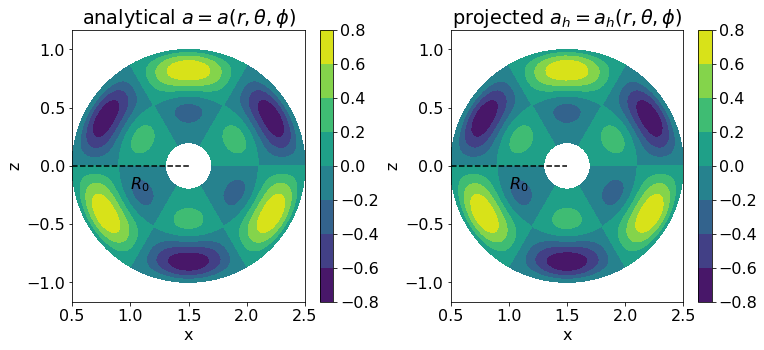

In [57]:
# ... plot analytical and numerical solution
plt.rcParams.update({'font.size': 16})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A = a(R, THETA, phiplot)

A_h = eva.evaluate_field_V0(a_vec, [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A_h = np.reshape(A_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.3)

plt.contourf(X, Z, A)
plt.colorbar()
plt.axis('equal')
plt.title(r'analytical $a=a(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.xlim((R0 - R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')


plt.subplot(1, 2, 2)

plt.contourf(X, Z, A_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_h=a_h(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.xlim((R0 - R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/0_form.pdf', bbox_inches = 'tight')

## Convergence for radial variation only

In [62]:
# ... component of 0-form to be projected
a = lambda r, theta, phi : r*np.sin(2*np.pi*r)

# ... mass matrix in V0
M0 = ma.mass_matrix_V0(p, Nbase, T, g_sqrt, bc)

# ... L2-scalar product in V0
a_int = ma.L2_prod_V0(a, p, Nbase, T, g_sqrt, bc)

# ... solve system
a_vec = sparse.linalg.spsolve(M0, a_int)

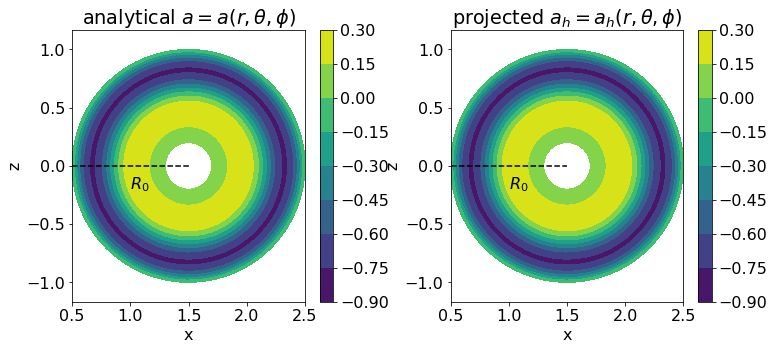

In [63]:
# ... plot analytical and numerical solution
plt.rcParams.update({'font.size': 16})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A = a(R, THETA, phiplot)

A_h = eva.evaluate_field_V0(a_vec, [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A_h = np.reshape(A_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.3)

plt.contourf(X, Z, A)
plt.colorbar()
plt.axis('equal')
plt.title(r'analytical $a=a(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.xlim((R0 - R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')


plt.subplot(1, 2, 2)

plt.contourf(X, Z, A_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_h=a_h(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.text(1.0, -0.2, '$R_0$')

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/0_form_convergence1.pdf', bbox_inches = 'tight')

In [64]:
# convergence in L2-norm

cases = 4
L2_error = np.zeros(cases)
H = np.zeros(cases)

cases_e = 5
cases_p = 2

L2_error = np.zeros((cases_e, cases_p))
H = np.zeros((cases_e, cases_p))

for j in range(2, cases_p + 2):
    for i in range(1, cases_e + 1):
    
        # ... number of elements and element boundaries in each direction
        Nel_x = 2*2**i
        Nel_y = 2
        Nel_z = 2

        el_b_x = np.linspace(0., 1., Nel_x + 1)
        el_b_y = np.linspace(0., 1., Nel_y + 1)
        el_b_z = np.linspace(0., 1., Nel_z + 1)

        dx = 1/Nel_x
        dy = 1/Nel_y
        dz = 1/Nel_z
        
        # ... degree of spline basis (of the 0-forms) in each direction
        p = [j, 2, 2]
        px, py, pz = p


        # ... number of basis functions
        Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
        Nbase_x, Nbase_y, Nbase_z = Nbase



        # ... knot vectors and number of degrees of freedom
        if bc_x == True:
            Tx = inter.make_periodic_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x - px

        elif bc_x == False:
            Tx = inter.make_open_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x - 2

        else:
            Tx = inter.make_open_knots(px, Nbase_x)
            Nbase_x_0 = Nbase_x


        if bc_y == True:
            Ty = inter.make_periodic_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y - py

        elif bc_y == False:
            Ty = inter.make_open_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y - 2

        else:
            Ty = inter.make_open_knots(py, Nbase_y)
            Nbase_y_0 = Nbase_y


        if bc_z == True:
            Tz = inter.make_periodic_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z - pz

        elif bc_z == False:
            Tz = inter.make_open_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z - 2

        else:
            Tz = inter.make_open_knots(pz, Nbase_z)
            Nbase_z_0 = Nbase_z

        T = [Tx, Ty, Tz]


        # ... mass matrix in V0
        M0 = ma.mass_matrix_V0(p, Nbase, T, g_sqrt, bc)

        # ... L2-scalar product in V0
        a_int = ma.L2_prod_V0(a, p, Nbase, T, g_sqrt, bc)

        # ... solve system
        a_vec = sparse.linalg.spsolve(M0, a_int)
        
        # ... L2 error
        pts_x_loc, wts_x_loc = np.polynomial.legendre.leggauss(px + 1)
        pts_y_loc, wts_y_loc = np.polynomial.legendre.leggauss(py + 1)
        pts_z_loc, wts_z_loc = np.polynomial.legendre.leggauss(pz + 1)

        pts_x, wts_x = inter.construct_quadrature_grid(Nel_x, px + 1, pts_x_loc, wts_x_loc, el_b_x)
        pts_y, wts_y = inter.construct_quadrature_grid(Nel_y, py + 1, pts_y_loc, wts_y_loc, el_b_y)
        pts_z, wts_z = inter.construct_quadrature_grid(Nel_z, pz + 1, pts_z_loc, wts_z_loc, el_b_z)

        ff = np.empty((px + 1, py + 1, pz + 1, Nel_x, Nel_y, Nel_z), order='F') 


        for nx in range(Nel_x):
            for ny in range(Nel_y):
                for nz in range(Nel_z):

                    ptx = pts_x[:, nx]
                    pty = pts_y[:, ny]
                    ptz = pts_z[:, nz]

                    R, THETA, PHI = np.meshgrid(ptx, pty, ptz, indexing='ij')

                    A = a(R, THETA, PHI)

                    A_h = eva.evaluate_field_V0(a_vec, [ptx, pty, ptz], p, Nbase, T, bc)
                    A_h = np.reshape(A_h, (px + 1, py + 1, pz + 1))


                    ff[:, :, :, nx, ny, nz] = (A - A_h)**2*g_sqrt(R, THETA, PHI)  



        L2_error[i - 1, j - 2] = np.sqrt(integr.integrate_3d_fast([pts_x, pts_y, pts_z], [wts_x, wts_y, wts_z], ff).sum()) 
        print('case ' + str(i) + ' done!: error = ' + str(L2_error[i - 1, j - 2]))

        H[i - 1, j - 2] = dx

case 1 done!: error = 0.10459935206024543
case 2 done!: error = 0.0076816078592474605
case 3 done!: error = 0.0008229290900803415
case 4 done!: error = 0.00010119364009666201
case 5 done!: error = 1.2761723869434832e-05
case 1 done!: error = 0.024873272361189126
case 2 done!: error = 0.001557745518239412
case 3 done!: error = 8.334683664669906e-05
case 4 done!: error = 4.987051720500853e-06
case 5 done!: error = 3.0887362945650504e-07


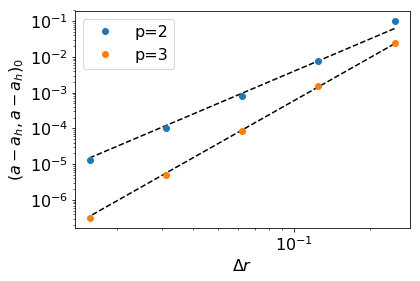

In [65]:
abcissea = np.array([4., 6.])

for j in range(cases_p):
    plt.loglog(H[:, j], abcissea[j]*H[:, j]**(j + 3), 'k--')
    plt.loglog(H[:, j], L2_error[:, j], 'o', label = 'p=' + str(j + 2))
    
    
plt.xlabel('$\Delta r$')
plt.ylabel('$(a - a_h, a - a_h)_0$')
plt.legend()

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/0_form_convergence2.pdf', bbox_inches = 'tight')

# 2. Space $V_1$

We want to project the components of a 1-form $\alpha^1=a_1(q_1,q_2,q_3)dq^1+a_2(q_1,q_2,q_3)dq^2+a_3(q_1,q_2,q_3)dq^3$ with $\mathbf{a}=(a_1,a_2,a_3)$.

In [88]:
# ... components of 1-form to be projected

a1 = lambda r, theta, phi : r*np.exp(-2*r**2)*np.sin(6*np.pi*theta)
a2 = lambda r, theta, phi : r*(1 - r)*np.sin(4*np.pi*theta)
a3 = lambda r, theta, phi : 0*r*theta*phi

a_bold = [lambda r, theta, phi : a1(r, theta, phi), lambda r, theta, phi : a2(r, theta, phi), lambda r, theta, phi : a3(r, theta, phi)]

In [89]:
# ... mass matrix in V1
M1 = ma.mass_matrix_V1(p, Nbase, T, Ginv, g_sqrt, bc)

In [90]:
# ... L2-scalar product in V1
a_bold_int = ma.L2_prod_V1(a_bold, p, Nbase, T, Ginv, g_sqrt, bc)

In [91]:
# ... solve system
a_bold_vec = sparse.linalg.spsolve(M1, a_bold_int)

a_bold_vec_1 = a_bold_vec[:(Nbase_x_0 - 1)*Nbase_y_0*Nbase_z_0]
a_bold_vec_2 = a_bold_vec[(Nbase_x_0 - 1)*Nbase_y_0*Nbase_z_0:(Nbase_x_0 - 1)*Nbase_y_0*Nbase_z_0 + Nbase_x_0*Nbase_y_0*Nbase_z_0]
a_bold_vec_3 = a_bold_vec[(Nbase_x_0 - 1)*Nbase_y_0*Nbase_z_0 + Nbase_x_0*Nbase_y_0*Nbase_z_0:(Nbase_x_0 - 1)*Nbase_y_0*Nbase_z_0 + Nbase_x_0*Nbase_y_0*Nbase_z_0*2]

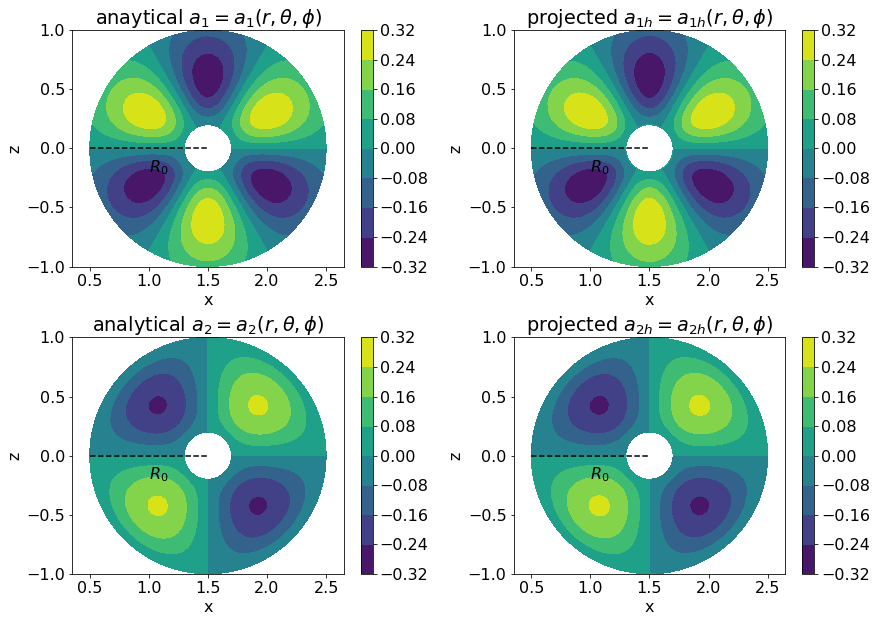

In [92]:
# ... plot analytical and numerical solution
plt.rcParams.update({'font.size': 16})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A1 = a1(R, THETA, phiplot)
A2 = a2(R, THETA, phiplot)

A1_h = eva.evaluate_field_V1_x(a_bold_vec_1, [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A2_h = eva.evaluate_field_V1_y(a_bold_vec_2, [rplot, thetaplot, phiplot], p, Nbase, T, bc)

A1_h = np.reshape(A1_h, (100, 100))
A2_h = np.reshape(A2_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

f = plt.figure()
f.set_figwidth(14)
f.set_figheight(10)

plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)


plt.contourf(X, Z, A1)
plt.colorbar()
plt.axis('equal')
plt.title(r'anaytical $a_1=a_1(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.subplot(2, 2, 2)

plt.contourf(X, Z, A1_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_{1h}=a_{1h}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')


plt.subplot(2, 2, 3)

plt.contourf(X, Z, A2)
plt.colorbar()
plt.axis('equal')
plt.title(r'analytical $a_2=a_2(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.subplot(2, 2, 4)

plt.contourf(X, Z, A2_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_{2h}=a_{2h}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/1_form.pdf', bbox_inches = 'tight')

# 3. Space $V_2$

We want to project the components of a 2-form $\alpha^2=a_{23}(q_1,q_2,q_3)dq^2\wedge dq^3+a_{31}(q_1,q_2,q_3)dq^3\wedge dq^1+a_{12}(q_1,q_2,q_3)dq^1\wedge dq^2$ with $\hat{\mathbf{a}}=(a_{23},a_{31},a_{12})$.

In [148]:
# ... components of 2-form to be projected

a23 = lambda r, theta, phi : r*np.exp(-2*r**2)*np.sin(6*np.pi*theta)
a31 = lambda r, theta, phi : r*(1 - r)*np.sin(4*np.pi*theta)
a12 = lambda r, theta, phi : 0*r*theta*phi

a_hat = [lambda r, theta, phi : a23(r, theta, phi), lambda r, theta, phi : a31(r, theta, phi), lambda r, theta, phi : a12(r, theta, phi)]

In [149]:
# ... mass matrix in V2
M2 = ma.mass_matrix_V2(p, Nbase, T, G, g_sqrt, bc)

In [150]:
# ... L2-scalar product in V2
a_hat_int = ma.L2_prod_V2(a_hat, p, Nbase, T, G, g_sqrt, bc)

In [151]:
# ... solve system
a_hat_vec = sparse.linalg.spsolve(M2, a_hat_int)

a_hat_vec_23 = a_hat_vec[:Nbase_x_0*Nbase_y_0*Nbase_z_0]
a_hat_vec_31 = a_hat_vec[Nbase_x_0*Nbase_y_0*Nbase_z_0:Nbase_x_0*Nbase_y_0*Nbase_z_0 + (Nbase_x_0 - 1)*Nbase_y_0*Nbase_z_0]
a_hat_vec_12 = a_hat_vec[Nbase_x_0*Nbase_y_0*Nbase_z_0 + (Nbase_x_0 - 1)*Nbase_y_0*Nbase_z_0:]

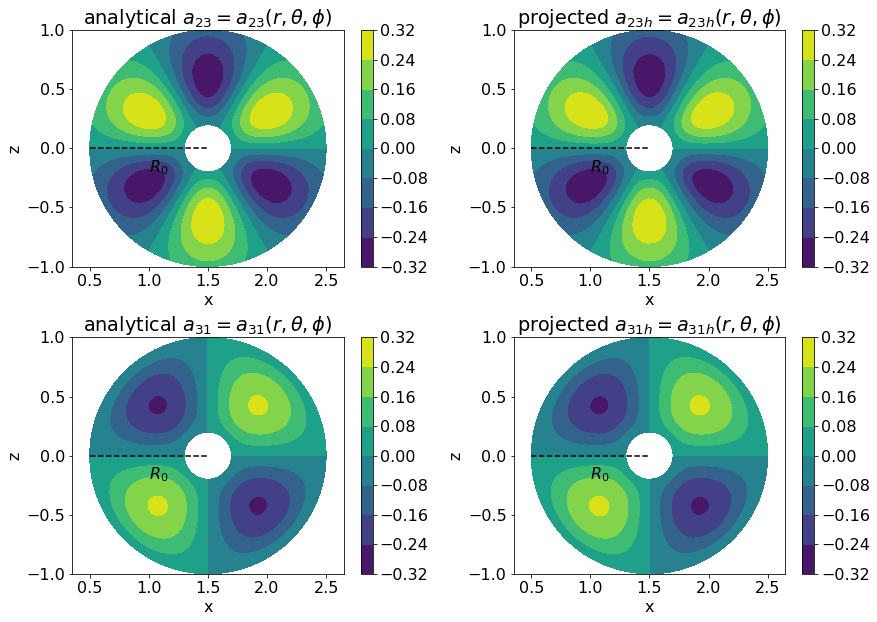

In [152]:
# ... plot analytical and numerical solution
plt.rcParams.update({'font.size': 16})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A23 = a23(R, THETA, phiplot)
A31 = a31(R, THETA, phiplot)

A23_h = eva.evaluate_field_V2_x(a_hat_vec_23, [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A31_h = eva.evaluate_field_V2_y(a_hat_vec_31, [rplot, thetaplot, phiplot], p, Nbase, T, bc)

A23_h = np.reshape(A23_h, (100, 100))
A31_h = np.reshape(A31_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

f = plt.figure()
f.set_figwidth(14)
f.set_figheight(10)

plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.contourf(X, Z, A23)
plt.colorbar()
plt.axis('equal')
plt.title(r'analytical $a_{23}=a_{23}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.subplot(2, 2, 2)

plt.contourf(X, Z, A23_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_{23h}=a_{23h}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')


plt.subplot(2, 2, 3)

plt.contourf(X, Z, A31)
plt.colorbar()
plt.axis('equal')
plt.title(r'analytical $a_{31}=a_{31}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.subplot(2, 2, 4)

plt.contourf(X, Z, A31_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_{31h}=a_{31h}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/2_form.pdf', bbox_inches = 'tight')

## Projection

In [159]:
# ... components of 2-form to be projected

a23 = lambda r, theta, phi : r*np.sin(2*np.pi*r)*np.sin(4*np.pi*theta)
a31 = lambda r, theta, phi : 1/(4*np.pi)*(np.sin(2*np.pi*r) + r*np.cos(2*np.pi*r)*2*np.pi)*np.cos(4*np.pi*theta)
a12 = lambda r, theta, phi : 0*r*theta*phi

In [160]:
a_hat_vec_23 = proj.PI_2_x(a23, p, Nbase, T, bc)
a_hat_vec_31 = proj.PI_2_y(a31, p, Nbase, T, bc)
a_hat_vec_12 = proj.PI_2_z(a12, p, Nbase, T, bc)

a_hat_vec = np.append(a_hat_vec_23, np.append(a_hat_vec_31, a_hat_vec_12))

In [161]:
DIV = der.DIV_3d(p, Nbase, bc)

In [162]:
a123_vec = DIV.dot(a_hat_vec)

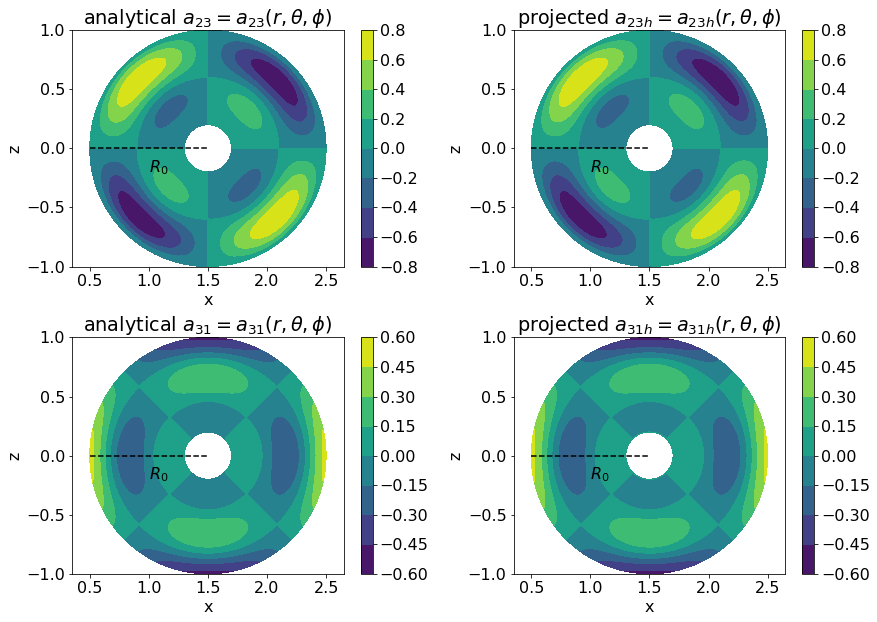

In [163]:
# ... plot analytical and numerical solution
plt.rcParams.update({'font.size': 16})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A23 = a23(R, THETA, phiplot)
A31 = a31(R, THETA, phiplot)

A23_h = eva.evaluate_field_V2_x(a_hat_vec_23, [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A31_h = eva.evaluate_field_V2_y(a_hat_vec_31, [rplot, thetaplot, phiplot], p, Nbase, T, bc)

A23_h = np.reshape(A23_h, (100, 100))
A31_h = np.reshape(A31_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

f = plt.figure()
f.set_figwidth(14)
f.set_figheight(10)

plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.contourf(X, Z, A23)
plt.colorbar()
plt.axis('equal')
plt.title(r'analytical $a_{23}=a_{23}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.subplot(2, 2, 2)

plt.contourf(X, Z, A23_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_{23h}=a_{23h}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')


plt.subplot(2, 2, 3)

plt.contourf(X, Z, A31)
plt.colorbar()
plt.axis('equal')
plt.title(r'analytical $a_{31}=a_{31}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.subplot(2, 2, 4)

plt.contourf(X, Z, A31_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'projected $a_{31h}=a_{31h}(r,\theta,\phi)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/2_form_commuting.pdf', bbox_inches = 'tight')

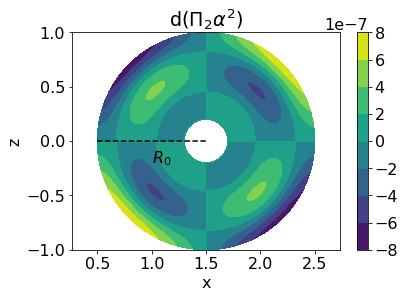

In [165]:
# ... plot divergence of projected form
plt.rcParams.update({'font.size': 16})

phiplot = np.array([0.0])

rplot = np.linspace(0., 1., 100)
thetaplot = np.linspace(0., 1., 100)

R, THETA = np.meshgrid(rplot, thetaplot, indexing = 'ij')

A123_h = eva.evaluate_field_V3(a123_vec, [rplot, thetaplot, phiplot], p, Nbase, T, bc)
A123_h = np.reshape(A123_h, (100, 100))

X, Z = xc(R, THETA, phiplot), zc(R, THETA, phiplot)

plt.contourf(X, Z, A123_h)
plt.colorbar()
plt.axis('equal')
plt.title(r'$\mathrm{d}(\Pi_2\alpha^2)$')
plt.xlabel('x')
plt.ylabel('z')
plt.xlim((R0 - R2, R0 + R2))
plt.xlim((R0 - R2, R0 + R2))
plt.plot(np.linspace(0.5, 1.5, 10), np.zeros(10), 'k--')
plt.text(1.0, -0.2, '$R_0$')

plt.savefig('/home/florian/Desktop/PHD/04_Präsentationen/01_FEEC/01_Figures/2_form_commuting2.pdf', bbox_inches = 'tight')

# 4. Space $V_3$

We want to project the component of a 3-form $\alpha^3=a_{123}(q_1,q_2,q_3)dq1\wedge dq^2\wedge dq^3$.

In [3]:
# ... component of 3-form to be projected

a123 = lambda r, phi, z : r*(1 - r)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)

In [4]:
# ... mass matrix in V3
M3 = ma.mass_matrix_V3(p, Nbase, T, g, bc)

In [8]:
# ... L2-scalar product in V3
a123_int = ma.L2_prod_V3(a123, p, Nbase, T, g, bc)

In [9]:
# ... solve system
a123_vec = sparse.linalg.spsolve(M3, a123_int)

Text(0,0.5,'y')

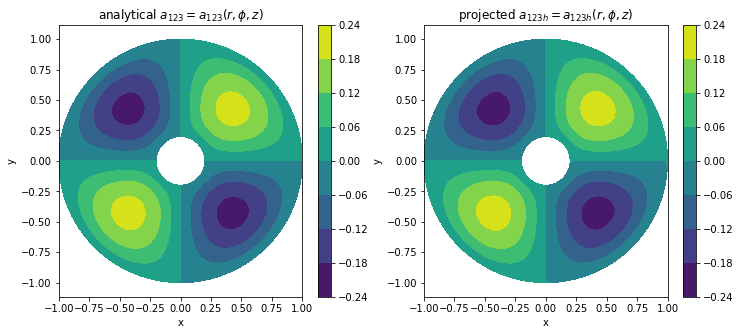

In [11]:
# ... plot analytical and numerical solution

zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing = 'ij')

A123 = a123(R, PHI, zplot)

A123_h = eva.evaluate_field_V3(a123_vec, [rplot, phiplot, zplot], p, Nbase, T, bc)
A123_h = np.reshape(A123_h, (100, 100))

X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1, 2, 1)

plt.contourf(X, Y, A123)
plt.colorbar()
plt.axis('equal')
plt.title('analytical $a_{123}=a_{123}(r,\phi,z)$')
plt.xlabel('x')
plt.ylabel('y')


plt.subplot(1, 2, 2)

plt.contourf(X, Y, A123_h)
plt.colorbar()
plt.axis('equal')
plt.title('projected $a_{123h}=a_{123h}(r,\phi,z)$')
plt.xlabel('x')
plt.ylabel('y')